# FIN30150: Financial Economics 1: Group Project
Odhran Murphy 19469442
Hugo Brady xxx
Mark Mullins xxx

## Import Libraries

In [64]:
# Import the standard data analysis libraries
import pandas as pd
import numpy as np

# Plotting library
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use("seaborn-darkgrid")
matplotlib.rcParams['figure.figsize']=[10,6]

# OLS Regression Library
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf

# Import specific libraries to read in data
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()
import datetime
from datetime import datetime

# OS Module
import os

# Import other modules
from IPython.display import Markdown

## Download Data

__Dateparsers for Fama French data__

In [2]:
# Dateparser to read in Fama French data so that the pandas read data function
# recognises the date format in the first column (where dates are expressed as 202009 for Sep 2020)
dateparserFF = lambda x: datetime.strptime(x, '%Y%m')

# Check that date parser works on a given date
print(dateparserFF('202009'))

2020-09-01 00:00:00


### Set GitHub Repository

In [3]:
base_url = 'https://raw.githubusercontent.com/odhran-murphy/FE1_Group_Project/main' 

### Read Fama French data

#### 3 factor monthly data

In [4]:
filename = 'FF_data_2022_monthly.csv'
df_ff_3f = pd.read_csv(f'{base_url}/{filename}', parse_dates=['Date'], date_parser=dateparserFF)

#Offset FF data to last business day of month as it should be
df_ff_3f['Date'] = pd.DatetimeIndex(df_ff_3f['Date']) + pd.offsets.BMonthEnd(1) 
df_ff_3f.set_index('Date',inplace=True)
df_ff_3f = df_ff_3f.divide(100)

# Converting all FF column names to lower case to avoid duplicates with SP500 ticker names
df_ff_3f = df_ff_3f.rename(columns=str.lower)

df_ff_3f

,mkt-rf,smb,hml,rf
Date,,,,
1926-07-30,0.0296,-0.0256,-0.0243,0.0022
1926-08-31,0.0264,-0.0117,0.0382,0.0025
1926-09-30,0.0036,-0.0140,0.0013,0.0023
1926-10-29,-0.0324,-0.0009,0.0070,0.0032
1926-11-30,0.0253,-0.0010,-0.0051,0.0031
...,...,...,...,...
2022-05-31,-0.0034,-0.0185,0.0841,0.0003
2022-06-30,-0.0843,0.0209,-0.0597,0.0006
2022-07-29,0.0957,0.0281,-0.0410,0.0008


#### 5 factor monthly data

In [5]:
filename = 'FF_data_2022_monthly_5f.csv'
df_ff_5f = pd.read_csv(f'{base_url}/{filename}', parse_dates=['Date'], date_parser=dateparserFF)

#Offset FF data to last business day of month as it should be
df_ff_5f['Date'] = pd.DatetimeIndex(df_ff_5f['Date']) + pd.offsets.BMonthEnd(1) 
df_ff_5f.set_index('Date',inplace=True)
df_ff_5f = df_ff_5f.divide(100)

# Converting all FF column names to lower case to avoid duplicates with SP500 ticker names
df_ff_5f = df_ff_5f.rename(columns=str.lower)
df_ff_5f

,mkt-rf,smb,hml,rmw,cma,rf
Date,,,,,,
1963-07-31,-0.0039,-0.0041,-0.0097,0.0068,-0.0118,0.0027
1963-08-30,0.0507,-0.0080,0.0180,0.0036,-0.0035,0.0025
1963-09-30,-0.0157,-0.0052,0.0013,-0.0071,0.0029,0.0027
1963-10-31,0.0253,-0.0139,-0.0010,0.0280,-0.0201,0.0029
1963-11-29,-0.0085,-0.0088,0.0175,-0.0051,0.0224,0.0027
...,...,...,...,...,...,...
2022-05-31,-0.0034,-0.0006,0.0841,0.0144,0.0398,0.0003
2022-06-30,-0.0843,0.0130,-0.0597,0.0185,-0.0470,0.0006
2022-07-29,0.0957,0.0188,-0.0410,0.0068,-0.0694,0.0008


_Set start and end dates_

In [6]:
start = datetime(1989,12,1)
end = datetime(2022,12,31)

#### SP500 and SP500 constituents data

##### Download SP500 data

In [7]:
#Download and save dataset (Only download if data has not already been downloaded)
target = 'SP500.csv'

if not os.path.isfile(target):
    df_sp_500 = pdr.get_data_yahoo('^GSPC', start, end, interval = '1mo')
    df_sp_500.to_csv(target)
        
df_sp_500 = pd.read_csv(f'{base_url}/{target}') # Always using saved dataset
df_sp_500.set_index('Date',inplace=True) 
df_sp_500_adj_close = df_sp_500.drop(columns=['Open','High','Low','Close','Volume'])
df_sp_500_adj_close.rename(columns={'Adj Close': 'SP500'}, inplace=True)
df_sp_500_adj_close

,SP500
Date,
1989-12-01,353.399994
1990-01-01,329.079987
1990-02-01,331.890015
1990-03-01,339.940002
1990-04-01,330.799988
...,...
2022-08-01,3955.000000
2022-09-01,3585.620117
2022-10-01,3871.979980


##### Download SP500 constituents data

In [8]:
#Download table with constituents

table = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies') # reads in tables from url
df_sp500_constituents = table[0] # Table of SP500 constituents at 14th November 2022

# Table of changes of SP500 constituents since 17th June 1997 - Work In Progress - try remove survivorship bias
df_sp500_constituents_changes = table[1] 

# Potential way to remove survivorship bias
# https://teddykoker.com/2019/05/creating-a-survivorship-bias-free-sp-500-dataset-with-python/

display(df_sp500_constituents)

,Symbol,Security,SEC filings,GICS Sector,GICS Sub-Industry,Headquarters Location,Date first added,CIK,Founded
0,MMM,3M,reports,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1976-08-09,66740,1902
1,AOS,A. O. Smith,reports,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888
3,ABBV,AbbVie,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ABMD,Abiomed,reports,Health Care,Health Care Equipment,"Danvers, Massachusetts",2018-05-31,815094,1981
...,...,...,...,...,...,...,...,...,...
498,YUM,Yum! Brands,reports,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,1997
499,ZBRA,Zebra Technologies,reports,Information Technology,Electronic Equipment & Instruments,"Lincolnshire, Illinois",2019-12-23,877212,1969
500,ZBH,Zimmer Biomet,reports,Health Care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,1136869,1927
501,ZION,Zions Bancorporation,reports,Financials,Regional Banks,"Salt Lake City, Utah",2001-06-22,109380,1873


In [9]:
#Download and save dataset (Only download if data has not already been downloaded)
target = 'SP500_constituents_adj_close.csv'

N = len(df_sp500_constituents['Symbol'])
tickers_list = df_sp500_constituents.loc[:N,'Symbol'].tolist()

if not os.path.isfile(target):
    df_sp500_constituents_data = pdr.get_data_yahoo(tickers_list, start, end, interval = '1mo')
    set(df_sp500_constituents_data.columns.get_level_values(0))
    df_sp500_constituents_data = df_sp500_constituents_data['Adj Close']
    df_sp500_constituents_data.to_csv(target)

df_sp500_constituents_data = pd.read_csv(f'{base_url}/{target}') # Always using saved dataset
df_sp500_constituents_data.set_index('Date',inplace=True) 
df_sp500_constituents_data

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACGL,ACN,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
1989-12-01,NaN,NaN,NaN,0.250664,NaN,NaN,5.500000,1.830009,NaN,NaN,...,NaN,4.172812,4.134922,0.848284,NaN,NaN,NaN,NaN,1.845269,NaN
1990-01-01,NaN,NaN,NaN,0.241775,NaN,NaN,4.562500,1.749274,NaN,NaN,...,NaN,3.965566,3.886824,0.848284,NaN,NaN,NaN,NaN,1.752264,NaN
1990-02-01,NaN,NaN,NaN,0.241775,NaN,NaN,4.562500,1.734572,NaN,NaN,...,NaN,3.885725,3.886824,0.830972,NaN,NaN,NaN,NaN,1.853357,NaN
1990-03-01,NaN,NaN,NaN,0.287141,NaN,NaN,5.125000,1.778527,NaN,NaN,...,NaN,3.872416,3.873215,0.813661,NaN,NaN,NaN,NaN,1.836507,NaN
1990-04-01,NaN,NaN,NaN,0.280900,NaN,NaN,4.750000,1.805578,NaN,NaN,...,NaN,3.566349,3.789470,0.805004,NaN,NaN,NaN,NaN,2.014277,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-01,128.028427,12.99,167.152359,156.741913,133.105606,145.657196,259.279999,102.167931,45.720001,287.182892,...,60.590000,73.767395,93.914124,32.632450,90.800819,110.697227,106.082695,301.640015,54.205685,156.198105
2022-09-01,121.340004,12.04,154.960861,137.971115,132.858124,134.915085,245.660004,96.305595,45.540001,256.160858,...,63.029999,63.584019,86.612747,28.231003,87.360001,106.339996,104.316650,262.010010,50.448788,147.975571
2022-10-01,138.110977,14.18,189.919998,153.086044,144.925323,156.737976,252.080002,98.475357,57.500000,282.643097,...,63.900002,65.110001,109.925072,30.820000,102.430000,118.250000,113.349998,283.220001,51.520054,150.460297


#### SP100 and SP100 constituents data

##### Download SP100 data

In [10]:
#Download and save dataset (Only download if data has not already been downloaded)
target = 'SP100.csv'

if not os.path.isfile(target):
    df_sp_100 = pdr.get_data_yahoo('^OEX', start, end, interval = '1mo')
    df_sp_100.to_csv(target)
        
df_sp_100 = pd.read_csv(f'{base_url}/{target}') # Always using saved dataset
df_sp_100.set_index('Date',inplace=True) 
df_sp_100_adj_close = df_sp_100.drop(columns=['Open','High','Low','Close','Volume'])
df_sp_100_adj_close.rename(columns={'Adj Close': 'SP100'}, inplace=True)
df_sp_100_adj_close

,SP100
Date,
1989-12-01,164.675003
1990-01-01,153.940002
1990-02-01,156.240005
1990-03-01,160.014999
1990-04-01,157.115005
...,...
2022-08-01,1797.949951
2022-09-01,1625.760010
2022-10-01,1740.510010


##### Download SP100 constituents data

In [11]:
#List of SP100 companies
df_sp100_constituents = pd.read_csv("SP100_list.csv", encoding="latin1")
display(df_sp100_constituents)

,Symbol,Name,Sector
0,AAPL,Apple,Information Technology
1,ABBV,AbbVie,Health Care
2,ABT,Abbott Laboratories,Health Care
3,ACN,Accenture,Information Technology
4,ADBE,Adobe,Information Technology
...,...,...,...
96,VZ,Verizon,Communication Services
97,WBA,Walgreens Boots Alliance,Consumer Staples
98,WFC,Wells Fargo,Financials
99,WMT,Walmart,Consumer Staples


In [12]:
#Download and save dataset (Only download if data has not already been downloaded)
target = 'SP100_constituents_adj_close.csv'

N = len(df_sp100_constituents['Symbol'])
tickers_list = df_sp100_constituents.loc[:N,'Symbol'].tolist()

if not os.path.isfile(target):
    df_sp100_constituents_data = pdr.get_data_yahoo(tickers_list, start, end, interval = '1mo')
    set(df_sp100_constituents_data.columns.get_level_values(0))
    df_sp100_constituents_data = df_sp100_constituents_data['Adj Close']
    df_sp100_constituents_data.to_csv(target)

df_sp100_constituents_data = pd.read_csv(f'{base_url}/{target}') # Always using saved dataset
df_sp100_constituents_data.set_index('Date',inplace=True) 
df_sp100_constituents_data

,AAPL,ABBV,ABT,ACN,ADBE,AIG,AMGN,AMT,AMZN,AVGO,...,UNH,UNP,UPS,USB,V,VZ,WBA,WFC,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
1989-12-01,0.250664,NaN,1.830009,NaN,1.188340,105.828514,0.765221,NaN,NaN,NaN,...,0.310161,3.211169,NaN,0.872812,NaN,5.769442,1.684878,1.127023,3.515244,4.134919
1990-01-01,0.241775,NaN,1.749273,NaN,1.379061,95.194878,0.730083,NaN,NaN,NaN,...,0.236618,3.141626,NaN,0.761773,NaN,5.069331,1.491162,1.039366,3.343113,3.886824
1990-02-01,0.241775,NaN,1.734571,NaN,1.779085,99.161308,0.897964,NaN,NaN,NaN,...,0.239815,3.210266,NaN,0.761773,NaN,4.706444,1.464131,0.986440,3.450956,3.886824
1990-03-01,0.287141,NaN,1.778528,NaN,2.234883,95.194878,0.964335,NaN,NaN,NaN,...,0.249408,3.062424,NaN,0.771796,NaN,4.942092,1.539057,0.999087,3.705856,3.873216
1990-04-01,0.280900,NaN,1.805578,NaN,2.253144,91.085503,0.999473,NaN,NaN,NaN,...,0.274988,2.894433,NaN,0.812125,NaN,4.896273,1.520950,0.910560,3.897904,3.789472
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-01,156.741898,133.105606,102.167931,287.182892,373.440002,51.444466,236.827271,252.210968,126.769997,494.959656,...,517.705566,223.254196,191.274475,45.081444,197.916306,41.117058,34.245155,43.133423,131.975220,93.914131
2022-09-01,137.971115,132.858124,96.305595,256.160858,275.200012,47.199673,223.858109,213.145813,113.000000,440.317871,...,503.460266,194.820007,160.042877,39.852745,177.253799,37.340702,31.034708,39.962620,129.699997,86.612747
2022-10-01,153.086044,144.925323,98.475357,282.643097,318.500000,57.000000,268.500641,205.690186,102.440002,470.119995,...,555.150024,197.139999,166.215149,42.450001,206.697998,36.750645,36.075378,45.695698,142.330002,109.925072


## Data Manipulation

#### SP500 data manipulation

In [13]:
# Concatenate SP500 and SP500 constituents data
df_sp_500_adj_close_master = pd.merge(df_sp_500_adj_close, df_sp500_constituents_data, how = 'left', left_index=True, right_index=True)

# End of month data but recorded in Python using first day of month
df_sp_500_adj_close_master.head()

,SP500,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACGL,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
1989-12-01,353.399994,NaN,NaN,NaN,0.250664,NaN,NaN,5.5000,1.830009,NaN,...,NaN,4.172812,4.134922,0.848284,NaN,NaN,NaN,NaN,1.845269,NaN
1990-01-01,329.079987,NaN,NaN,NaN,0.241775,NaN,NaN,4.5625,1.749274,NaN,...,NaN,3.965566,3.886824,0.848284,NaN,NaN,NaN,NaN,1.752264,NaN
1990-02-01,331.890015,NaN,NaN,NaN,0.241775,NaN,NaN,4.5625,1.734572,NaN,...,NaN,3.885725,3.886824,0.830972,NaN,NaN,NaN,NaN,1.853357,NaN
1990-03-01,339.940002,NaN,NaN,NaN,0.287141,NaN,NaN,5.1250,1.778527,NaN,...,NaN,3.872416,3.873215,0.813661,NaN,NaN,NaN,NaN,1.836507,NaN
1990-04-01,330.799988,NaN,NaN,NaN,0.280900,NaN,NaN,4.7500,1.805578,NaN,...,NaN,3.566349,3.789470,0.805004,NaN,NaN,NaN,NaN,2.014277,NaN


In [14]:
# Correcting data so day of month is business end of month
df_sp_500_adj_close_master.index = pd.to_datetime(df_sp_500_adj_close_master.index)
df_sp_500_adj_close_master = df_sp_500_adj_close_master.resample('M').last()
df_sp_500_adj_close_master.head()

,SP500,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACGL,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
1989-12-31,353.399994,NaN,NaN,NaN,0.250664,NaN,NaN,5.5000,1.830009,NaN,...,NaN,4.172812,4.134922,0.848284,NaN,NaN,NaN,NaN,1.845269,NaN
1990-01-31,329.079987,NaN,NaN,NaN,0.241775,NaN,NaN,4.5625,1.749274,NaN,...,NaN,3.965566,3.886824,0.848284,NaN,NaN,NaN,NaN,1.752264,NaN
1990-02-28,331.890015,NaN,NaN,NaN,0.241775,NaN,NaN,4.5625,1.734572,NaN,...,NaN,3.885725,3.886824,0.830972,NaN,NaN,NaN,NaN,1.853357,NaN
1990-03-31,339.940002,NaN,NaN,NaN,0.287141,NaN,NaN,5.1250,1.778527,NaN,...,NaN,3.872416,3.873215,0.813661,NaN,NaN,NaN,NaN,1.836507,NaN
1990-04-30,330.799988,NaN,NaN,NaN,0.280900,NaN,NaN,4.7500,1.805578,NaN,...,NaN,3.566349,3.789470,0.805004,NaN,NaN,NaN,NaN,2.014277,NaN


In [15]:
# Calculating returns dataframe
df_sp_500_rets = np.log(df_sp_500_adj_close_master/df_sp_500_adj_close_master.shift(1))
df_sp_500_rets.head()

,SP500,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACGL,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
1989-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-31,-0.071300,NaN,NaN,NaN,-0.036106,NaN,NaN,-0.186877,-0.045120,NaN,...,NaN,-0.050942,-0.061876,0.000000,NaN,NaN,NaN,NaN,-0.051716,NaN
1990-02-28,0.008503,NaN,NaN,NaN,0.000000,NaN,NaN,0.000000,-0.008440,NaN,...,NaN,-0.020339,0.000000,-0.020619,NaN,NaN,NaN,NaN,0.056089,NaN
1990-03-31,0.023966,NaN,NaN,NaN,0.171968,NaN,NaN,0.116260,0.025025,NaN,...,NaN,-0.003431,-0.003507,-0.021053,NaN,NaN,NaN,NaN,-0.009133,NaN
1990-04-30,-0.027255,NaN,NaN,NaN,-0.021978,NaN,NaN,-0.075986,0.015095,NaN,...,NaN,-0.082336,-0.021859,-0.010696,NaN,NaN,NaN,NaN,0.092395,NaN


In [16]:
# Merge 5 factor FF data and SP500 returns
df_sp_500_exrets = pd.merge(df_sp_500_rets,df_ff_5f, left_index = True, right_index = True)

# SP500 Excess Returns Calculation - 5 factor model
df_sp_500_exrets['SP500exret'] = df_sp_500_exrets['SP500'] - df_sp_500_exrets['rf']

df_sp_500_exrets.head()

,SP500,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACGL,...,ZBRA,ZION,ZTS,mkt-rf,smb,hml,rmw,cma,rf,SP500exret
Date,,,,,,,,,,,,,,,,,,,,,
1990-01-31,-0.071300,NaN,NaN,NaN,-0.036106,NaN,NaN,-0.186877,-0.045120,NaN,...,NaN,-0.051716,NaN,-0.0785,-0.0131,0.0085,-0.0117,0.0135,0.0057,-0.077000
1990-02-28,0.008503,NaN,NaN,NaN,0.000000,NaN,NaN,0.000000,-0.008440,NaN,...,NaN,0.056089,NaN,0.0111,0.0117,0.0064,-0.0003,-0.0066,0.0057,0.002803
1990-04-30,-0.027255,NaN,NaN,NaN,-0.021978,NaN,NaN,-0.075986,0.015095,NaN,...,NaN,0.092395,NaN,-0.0336,-0.0033,-0.0259,0.0178,-0.0098,0.0069,-0.034155
1990-05-31,0.088001,NaN,NaN,NaN,0.046520,NaN,NaN,0.223144,0.121131,NaN,...,NaN,0.000000,NaN,0.0842,-0.0235,-0.0383,0.0157,-0.0168,0.0068,0.081201
1990-07-31,-0.005237,NaN,NaN,NaN,-0.063423,NaN,NaN,-0.131928,0.059189,NaN,...,NaN,0.055510,NaN,-0.0190,-0.0316,-0.0003,-0.0018,0.0321,0.0068,-0.012037


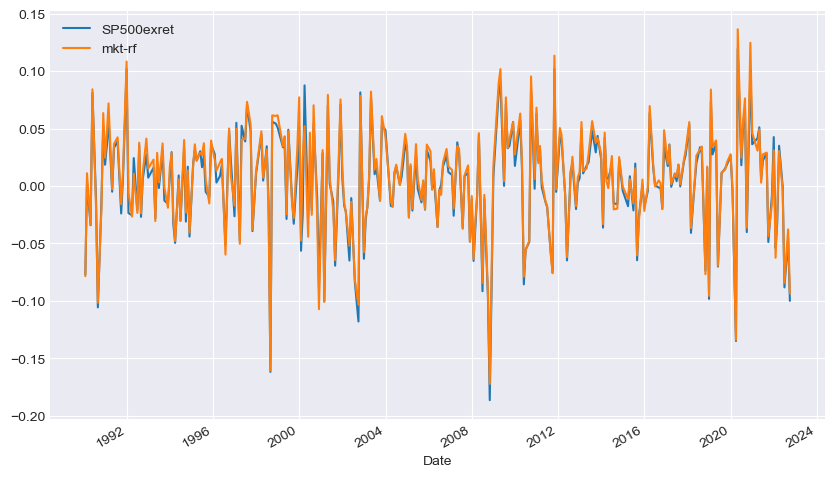

In [17]:
# Comparing SP500 excess returns to FF excess returns to check alignment
df_sp_500_exrets[['SP500exret', 'mkt-rf']].plot();

#### SP100 data manipulation

In [18]:
# Concatenate SP500 and SP500 constituents data
df_sp_100_adj_close_master = pd.merge(df_sp_100_adj_close, df_sp100_constituents_data, how = 'left', left_index=True, right_index=True)

# End of month data but recorded in Python using first day of month
df_sp_100_adj_close_master.head()

,SP100,AAPL,ABBV,ABT,ACN,ADBE,AIG,AMGN,AMT,AMZN,...,UNH,UNP,UPS,USB,V,VZ,WBA,WFC,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
1989-12-01,164.675003,0.250664,NaN,1.830009,NaN,1.188340,105.828514,0.765221,NaN,NaN,...,0.310161,3.211169,NaN,0.872812,NaN,5.769442,1.684878,1.127023,3.515244,4.134919
1990-01-01,153.940002,0.241775,NaN,1.749273,NaN,1.379061,95.194878,0.730083,NaN,NaN,...,0.236618,3.141626,NaN,0.761773,NaN,5.069331,1.491162,1.039366,3.343113,3.886824
1990-02-01,156.240005,0.241775,NaN,1.734571,NaN,1.779085,99.161308,0.897964,NaN,NaN,...,0.239815,3.210266,NaN,0.761773,NaN,4.706444,1.464131,0.986440,3.450956,3.886824
1990-03-01,160.014999,0.287141,NaN,1.778528,NaN,2.234883,95.194878,0.964335,NaN,NaN,...,0.249408,3.062424,NaN,0.771796,NaN,4.942092,1.539057,0.999087,3.705856,3.873216
1990-04-01,157.115005,0.280900,NaN,1.805578,NaN,2.253144,91.085503,0.999473,NaN,NaN,...,0.274988,2.894433,NaN,0.812125,NaN,4.896273,1.520950,0.910560,3.897904,3.789472


In [19]:
# Correcting data so day of month is business end of month
df_sp_100_adj_close_master.index = pd.to_datetime(df_sp_100_adj_close_master.index)
df_sp_100_adj_close_master = df_sp_100_adj_close_master.resample('M').last()
df_sp_100_adj_close_master.head()

,SP100,AAPL,ABBV,ABT,ACN,ADBE,AIG,AMGN,AMT,AMZN,...,UNH,UNP,UPS,USB,V,VZ,WBA,WFC,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
1989-12-31,164.675003,0.250664,NaN,1.830009,NaN,1.188340,105.828514,0.765221,NaN,NaN,...,0.310161,3.211169,NaN,0.872812,NaN,5.769442,1.684878,1.127023,3.515244,4.134919
1990-01-31,153.940002,0.241775,NaN,1.749273,NaN,1.379061,95.194878,0.730083,NaN,NaN,...,0.236618,3.141626,NaN,0.761773,NaN,5.069331,1.491162,1.039366,3.343113,3.886824
1990-02-28,156.240005,0.241775,NaN,1.734571,NaN,1.779085,99.161308,0.897964,NaN,NaN,...,0.239815,3.210266,NaN,0.761773,NaN,4.706444,1.464131,0.986440,3.450956,3.886824
1990-03-31,160.014999,0.287141,NaN,1.778528,NaN,2.234883,95.194878,0.964335,NaN,NaN,...,0.249408,3.062424,NaN,0.771796,NaN,4.942092,1.539057,0.999087,3.705856,3.873216
1990-04-30,157.115005,0.280900,NaN,1.805578,NaN,2.253144,91.085503,0.999473,NaN,NaN,...,0.274988,2.894433,NaN,0.812125,NaN,4.896273,1.520950,0.910560,3.897904,3.789472


In [20]:
# Calculating returns dataframe
df_sp_100_rets = np.log(df_sp_100_adj_close_master/df_sp_100_adj_close_master.shift(1))
df_sp_100_rets.head()

,SP100,AAPL,ABBV,ABT,ACN,ADBE,AIG,AMGN,AMT,AMZN,...,UNH,UNP,UPS,USB,V,VZ,WBA,WFC,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
1989-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-31,-0.067411,-0.036106,NaN,-0.045121,NaN,0.148846,-0.105894,-0.047006,NaN,NaN,...,-0.270643,-0.021895,NaN,-0.136072,NaN,-0.129367,-0.122138,-0.080969,-0.050206,-0.061875
1990-02-28,0.014830,0.000000,NaN,-0.008440,NaN,0.254696,0.040822,0.206971,NaN,NaN,...,0.013422,0.021613,NaN,0.000000,NaN,-0.074276,-0.018293,-0.052263,0.031749,0.000000
1990-03-31,0.023874,0.171968,NaN,0.025026,NaN,0.228090,-0.040822,0.071309,NaN,NaN,...,0.039221,-0.047147,NaN,0.013073,NaN,0.048856,0.049908,0.012739,0.071263,-0.003507
1990-04-30,-0.018290,-0.021978,NaN,0.015095,NaN,0.008138,-0.044127,0.035789,NaN,NaN,...,0.097638,-0.056418,NaN,0.050933,NaN,-0.009315,-0.011835,-0.092782,0.050525,-0.021859


In [21]:
# Merge 5 factor FF data and SP100 returns
df_sp_100_exrets = pd.merge(df_sp_100_rets,df_ff_5f, left_index = True, right_index = True)

# SP100 Excess Returns Calculation - 5 factor model
df_sp_100_exrets['SP100exret'] = df_sp_100_exrets['SP100'] - df_sp_100_exrets['rf']

display(df_sp_100_exrets)

,SP100,AAPL,ABBV,ABT,ACN,ADBE,AIG,AMGN,AMT,AMZN,...,WFC,WMT,XOM,mkt-rf,smb,hml,rmw,cma,rf,SP100exret
Date,,,,,,,,,,,,,,,,,,,,,
1990-01-31,-0.067411,-0.036106,NaN,-0.045121,NaN,0.148846,-0.105894,-0.047006,NaN,NaN,...,-0.080969,-0.050206,-0.061875,-0.0785,-0.0131,0.0085,-0.0117,0.0135,0.0057,-0.073111
1990-02-28,0.014830,0.000000,NaN,-0.008440,NaN,0.254696,0.040822,0.206971,NaN,NaN,...,-0.052263,0.031749,0.000000,0.0111,0.0117,0.0064,-0.0003,-0.0066,0.0057,0.009130
1990-04-30,-0.018290,-0.021978,NaN,0.015095,NaN,0.008138,-0.044127,0.035789,NaN,NaN,...,-0.092782,0.050525,-0.021859,-0.0336,-0.0033,-0.0259,0.0178,-0.0098,0.0069,-0.025190
1990-05-31,0.086613,0.046520,NaN,0.121131,NaN,-0.071096,0.132828,0.091397,NaN,NaN,...,0.229108,0.127532,0.058998,0.0842,-0.0235,-0.0383,0.0157,-0.0168,0.0068,0.079813
1990-07-31,-0.003301,-0.063424,NaN,0.059190,NaN,-0.045225,-0.019637,0.103751,NaN,NaN,...,-0.090151,0.007171,0.080244,-0.0190,-0.0316,-0.0003,-0.0018,0.0321,0.0068,-0.010101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-31,0.037910,0.057156,0.092618,-0.018914,0.064960,-0.026125,0.024677,0.074075,0.101952,0.059624,...,-0.092030,0.096950,0.062834,0.0305,-0.0215,-0.0180,-0.0156,0.0317,0.0001,0.037810
2022-05-31,-0.004244,-0.057505,0.011794,0.038273,-0.003373,0.050550,0.002901,0.096210,0.066136,-0.033313,...,0.047884,-0.173432,0.118760,-0.0034,-0.0006,0.0841,0.0144,0.0398,0.0003,-0.004544
2022-06-30,-0.081218,-0.083469,0.038537,-0.077966,-0.072275,-0.129041,-0.137728,-0.045766,-0.002111,-0.123818,...,-0.150266,-0.052739,-0.104005,-0.0843,0.0130,-0.0597,0.0185,-0.0470,0.0006,-0.081818


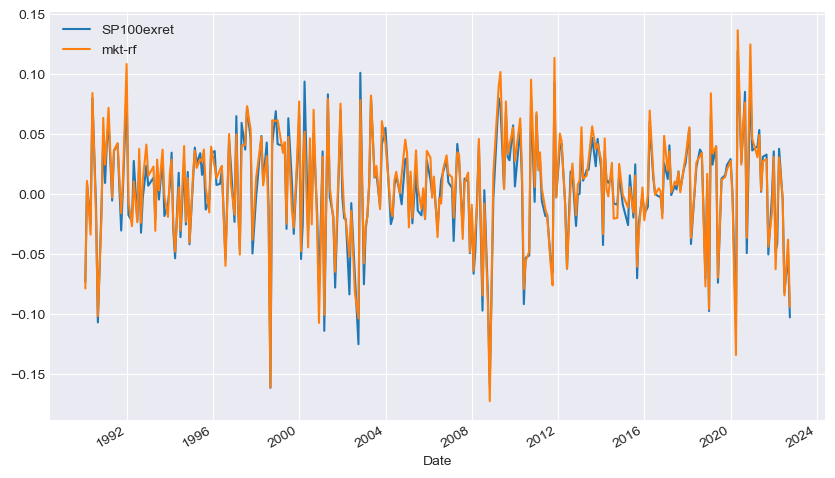

In [22]:
# Comparing SP100 excess returns to FF excess returns to check alignment
df_sp_100_exrets[['SP100exret', 'mkt-rf']].plot();

## Question 1

### 1 Factor Model (Example)

_First pass regression:_ Regress excess return of each SP500 constituent against SP500 excess returns to find SP500 constituent alpha and betas

In [23]:
# Initialise betas and mean returns
beta = np.zeros(N)
mean = np.zeros(N)

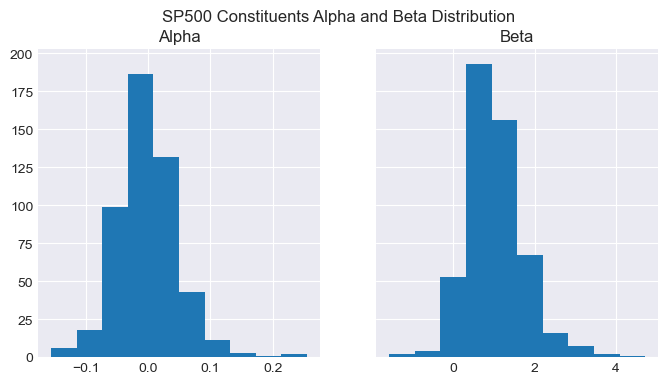

,alpha,beta
A,0.015131,0.828423
AAL,-0.021885,1.817861
AAP,-0.043087,0.673628
AAPL,-0.007434,1.067615
ABBV,0.034439,0.461765
...,...,...
YUM,-0.022774,0.413896
ZBH,-0.001433,0.785522
ZBRA,-0.069895,0.981100
ZION,-0.034097,0.342418


In [24]:
df_sp_500_exrets.dropna(axis=1, inplace = True, how='all')

x = df_sp_500_exrets['SP500exret']

stocks_array = df_sp_500_exrets.iloc[:,df_sp_500_exrets.columns.get_loc('A'):
                                     df_sp_500_exrets.columns.get_loc('ZTS')+1].values
rf_array = df_sp_500_exrets.loc[:,'rf'].values
rf_array = rf_array[:,np.newaxis]

y = stocks_array - rf_array # Array containing dependent variables in each column

X = sm.add_constant(x)
ts_res = sm.OLS(y, X, missing='drop').fit()
alpha = ts_res.params[0]
beta = ts_res.params[1:]

# Isolate alpha and beta
alpha = ts_res.params.iloc[0,:].values
beta = ts_res.params.iloc[1,:].values

# Plot Histogram of Alphas and Beta
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(8, 4))
axs[0].hist(alpha)
axs[0].set_title('Alpha')
axs[1].hist(beta)
axs[1].set_title('Beta')
plt.suptitle('SP500 Constituents Alpha and Beta Distribution')
plt.show()

# Format parameter datframe
ts_res.params = ts_res.params.rename(index={'const': 'alpha', 'SP500exret': 'beta'})
ts_res.params.columns = df_sp_500_exrets.iloc[:,df_sp_500_exrets.columns.get_loc('A'):
                                     df_sp_500_exrets.columns.get_loc('ZTS')+1].columns.values.tolist()
display(ts_res.params.T)

__CAPM Commentary__

Betas should not be negative. This is probably caused by noise. One could shrink these beta towards their average using Bayesian statistics.

_Second pass regression:_ Regress mean excess return of each SP500 constituent against SP100 constituent betas found in first pass regression

In [25]:
mean_exrets = np.nanmean(y, axis = 0)
mean_exrets = mean_exrets[:,np.newaxis]
print(mean_exrets.shape)

beta = beta[:,np.newaxis]
print(beta.shape)

(501, 1)
(501, 1)


In [26]:
ts_beta_mean = np.hstack((beta, mean_exrets))    
df_fm = pd.DataFrame(ts_beta_mean, index = df_sp_500_exrets.iloc[:,df_sp_500_exrets.columns.get_loc('A'):
                                                          df_sp_500_exrets.columns.get_loc('ZTS')+1].columns,
                    columns=['beta_capm', 'mean_exrets'])

# Second pass regression for returns
modelCS = sm.OLS.from_formula('mean_exrets ~ beta_capm', data=df_fm).fit()
print(modelCS.summary())
print('------------------------------------')
print('Annualised intercept', modelCS.params[0]*12)
print('Annualised risk premium', modelCS.params[1]*12)
print('Adj R-squared-adj', modelCS.rsquared_adj)
df_fm

                            OLS Regression Results                            
Dep. Variable:            mean_exrets   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     3.836
Date:                Wed, 30 Nov 2022   Prob (F-statistic):             0.0507
Time:                        12:53:10   Log-Likelihood:                 1793.5
No. Observations:                 501   AIC:                            -3583.
Df Residuals:                     499   BIC:                            -3575.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0090      0.001     16.770      0.0

,beta_capm,mean_exrets
A,0.828423,0.001768
AAL,1.817861,0.011206
AAP,0.673628,0.004822
AAPL,1.067615,0.013352
ABBV,0.461765,0.014445
...,...,...
YUM,0.413896,0.010164
ZBH,0.785522,0.004754
ZBRA,0.981100,0.011066
ZION,0.342418,0.006066


### 3 Factor Model

In [27]:
x_3fm = df_sp_500_exrets.loc[:,['SP500exret', 'smb', 'hml']] 

X_3fm = sm.add_constant(x_3fm)
ts_res_3fm = sm.OLS(y, X_3fm, missing='drop').fit()

alpha_3fm = ts_res_3fm.params[0]
betas_3fm = ts_res_3fm.params[1:]
betas_3fm.shape

(3, 501)

In [28]:
ts_beta_mean_3fm = np.hstack((betas_3fm.T, mean_exrets))
df_3fm = pd.DataFrame(ts_beta_mean_3fm, index = df_sp_500_exrets.iloc[:,df_sp_500_exrets.columns.get_loc('A'):
                                                          df_sp_500_exrets.columns.get_loc('ZTS')+1].columns,
                    columns=['beta_capm', 'beta_size', 'beta_val', 'mean_exrets'])

# Second pass regression for returns
modelCS_3fm = sm.OLS.from_formula('mean_exrets ~ beta_capm + beta_size + beta_val', data=df_3fm).fit()
print(modelCS_3fm.summary())
print('------------------------------------------------------------------------------')
print('Annualised intercept', modelCS_3fm.params[0]*12)
print('Annualised risk premium', modelCS_3fm.params[1]*12)
print('Annualised size premium', modelCS_3fm.params[2]*12)
print('Annualised value premium', modelCS_3fm.params[3]*12)
print('Adj R-squared-adj', modelCS_3fm.rsquared_adj)

                            OLS Regression Results                            
Dep. Variable:            mean_exrets   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     5.507
Date:                Wed, 30 Nov 2022   Prob (F-statistic):           0.000999
Time:                        12:53:10   Log-Likelihood:                 1799.7
No. Observations:                 501   AIC:                            -3591.
Df Residuals:                     497   BIC:                            -3575.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0089      0.001     16.865      0.0

### 5 Factor Model

In [29]:
x_5fm = df_sp_500_exrets.loc[:,['SP500exret', 'smb', 'hml', 'rmw', 'cma']] 

X_5fm = sm.add_constant(x_5fm)
ts_res_5fm = sm.OLS(y, X_5fm, missing='drop').fit()

alpha_5fm = ts_res_5fm.params[0]
betas_5fm = ts_res_5fm.params[1:]
betas_5fm.shape

(5, 501)

In [30]:
ts_beta_mean_5fm = np.hstack((betas_5fm.T, mean_exrets))
df_5fm = pd.DataFrame(ts_beta_mean_5fm, index = df_sp_500_exrets.iloc[:,df_sp_500_exrets.columns.get_loc('A'):
                                                          df_sp_500_exrets.columns.get_loc('ZTS')+1].columns,
                    columns=['beta_capm', 'beta_size', 'beta_val','beta_prof','beta_inv', 'mean_exrets'])

# Second pass regression for returns
modelCS_5fm = sm.OLS.from_formula('mean_exrets ~ beta_capm + beta_size + beta_val + beta_prof + beta_inv', 
                                  data=df_5fm).fit()
print(modelCS_5fm.summary())
print('------------------------------------------------------------------------------')
print('Annualised intercept', modelCS_5fm.params[0]*12)
print('Annualised risk premium', modelCS_5fm.params[1]*12)
print('Annualised size premium', modelCS_5fm.params[2]*12)
print('Annualised value premium', modelCS_5fm.params[3]*12)
print('Annualised profitability premium', modelCS_5fm.params[4]*12)
print('Annualised investment premium', modelCS_5fm.params[5]*12)
print('Adj R-squared-adj', modelCS_5fm.rsquared_adj)

                            OLS Regression Results                            
Dep. Variable:            mean_exrets   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     6.365
Date:                Wed, 30 Nov 2022   Prob (F-statistic):           9.64e-06
Time:                        12:53:10   Log-Likelihood:                 1807.2
No. Observations:                 501   AIC:                            -3602.
Df Residuals:                     495   BIC:                            -3577.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0099      0.001     15.893      0.0

### Question 1 Commentary
xxxx

## Question 2

##### CAPM to calculate expected excess returns

_First pass regression:_ Regress excess return of each SP100 constituent against SP100 excess returns to find SP100 constituent alpha and betas

In [31]:
# # Copy from question 3 - Change to SP100, redefine start and date time

# is_end_date = datetime(2010,12,31)
# os_start_date = datetime(2011,1,31)

# # SP100 excess returns within in sample period
# x = df_sp_100_exrets_new.loc[:is_end_date,'SP100exret']

# # Calculate excess return of each stock during in sample period
# stocks_array = df_sp_100_exrets_new.loc[:is_end_date,'AAPL':'XOM'].values 
# rf_array = df_sp_100_exrets_new.loc[:is_end_date,'rf'].values
# rf_array = rf_array[:,np.newaxis]
# y = stocks_array - rf_array # Array containing dependent variables in each column

# # OLS Regression
# X = sm.add_constant(x)
# ts_res = sm.OLS(y, X, missing='drop').fit()

# # alpha = ts_res.params[0]
# # beta = ts_res.params[1:]

# # Isolate alpha and beta
# alpha = ts_res.params.iloc[0,:].values
# beta = ts_res.params.iloc[1,:].values

_Second pass regression:_ Regress mean excess return of each SP100 constituent against SP100 constituent betas found in first pass regression

In [32]:
# mean_exrets = np.nanmean(y, axis = 0)
# mean_exrets = mean_exrets[:,np.newaxis]
# print(mean_exrets.shape)

# beta = beta[:,np.newaxis]
# print(beta.shape)

In [33]:
# ts_beta_mean = np.hstack((beta, mean_exrets))    
# df_fm = pd.DataFrame(ts_beta_mean, index = df_sp_100_exrets_new.loc[:is_end_date,'AAPL':'XOM'].columns,
#                     columns=['beta_m', 'mean_exrets'])

# # Second pass regression for returns
# modelCS = sm.OLS.from_formula('mean_exrets ~ beta_m', data=df_fm).fit()
# print(modelCS.summary())
# print('------------------------------------')
# print('Annualised intercept', modelCS.params[0]*12)
# print('Annualised risk premium', modelCS.params[1]*12)
# print('Adj R-squared-adj', modelCS.rsquared_adj)
# df_fm

In [34]:
# # sliding window calc (ASAD)

# intercept = 0 
# index = df_exrets - 60 # 5 years is out in sample period, index is length of out sample period

# for i in range(index):
    
#     # First pass regression
#     rolling_window = df_exrets.iloc[i:i+60,:]
#     rolling_window.dropna(axis=1, inplace=True)
#     x = rolling_window.loc[:,'SP100exret'] # change to SP500 excess ret
#     stocks_array = rolling_window.loc[:rolling_window,'AAPL':'XOM'].values # change to SP500 constituent columns 
#     rf_array = df_sp_100_exrets_new.loc[:is_end_date,'rf'].values
#     rf_array = rf_array[:,np.newaxis]
#     y = stocks_array - rf_array # Array containing dependent variables in each column
#     X = sm.add_constant(x)
#     ts_res = sm.OLS(y, X, missing='drop').fit()
#     alpha = ts_res.params[0]
#     beta = ts_res.params[1:]
    
#     # Second pass regression
#     tickers = rolling_window.loc[:rolling_window,'AAPL':'XOM'].columns.values.tolist()
#     next_month_rets = df_exrets.iloc[i:i+60,:][tickers]
#     ex_rets = next_month_rets - df_exrets.iloc[i+60, 'AAPL':'XOM'].values
#     ts_beta_mean = np.hstack((beta, ex_rets))
#     df_fm = pd.DataFrame(ts_beta_mean, index = [i for i in tickers], columns=['beta_rolling', 'ex_rets_rolling'])
#     modelCS = sm.OLS.from_formula('ex_rets_rolling ~ beta_rolling', data=df_fm).fit()
#     intercept += modelCS.params[0]*12

# print(intercept/index)

### Question 2 Commentary
xxxx

## Question 3

#### SP100, SP100 constituents dataframe and 5 factor FF dataframes

In [35]:
display(df_sp_100_exrets)
print(df_sp_100_exrets.isna().sum()) # Check number of missing values across columns
print('Number of missing values across entire dataframe:', 
      df_sp_100_exrets.isna().sum().sum()) # Check number of missing values across entire dataframe

,SP100,AAPL,ABBV,ABT,ACN,ADBE,AIG,AMGN,AMT,AMZN,...,WFC,WMT,XOM,mkt-rf,smb,hml,rmw,cma,rf,SP100exret
Date,,,,,,,,,,,,,,,,,,,,,
1990-01-31,-0.067411,-0.036106,NaN,-0.045121,NaN,0.148846,-0.105894,-0.047006,NaN,NaN,...,-0.080969,-0.050206,-0.061875,-0.0785,-0.0131,0.0085,-0.0117,0.0135,0.0057,-0.073111
1990-02-28,0.014830,0.000000,NaN,-0.008440,NaN,0.254696,0.040822,0.206971,NaN,NaN,...,-0.052263,0.031749,0.000000,0.0111,0.0117,0.0064,-0.0003,-0.0066,0.0057,0.009130
1990-04-30,-0.018290,-0.021978,NaN,0.015095,NaN,0.008138,-0.044127,0.035789,NaN,NaN,...,-0.092782,0.050525,-0.021859,-0.0336,-0.0033,-0.0259,0.0178,-0.0098,0.0069,-0.025190
1990-05-31,0.086613,0.046520,NaN,0.121131,NaN,-0.071096,0.132828,0.091397,NaN,NaN,...,0.229108,0.127532,0.058998,0.0842,-0.0235,-0.0383,0.0157,-0.0168,0.0068,0.079813
1990-07-31,-0.003301,-0.063424,NaN,0.059190,NaN,-0.045225,-0.019637,0.103751,NaN,NaN,...,-0.090151,0.007171,0.080244,-0.0190,-0.0316,-0.0003,-0.0018,0.0321,0.0068,-0.010101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-31,0.037910,0.057156,0.092618,-0.018914,0.064960,-0.026125,0.024677,0.074075,0.101952,0.059624,...,-0.092030,0.096950,0.062834,0.0305,-0.0215,-0.0180,-0.0156,0.0317,0.0001,0.037810
2022-05-31,-0.004244,-0.057505,0.011794,0.038273,-0.003373,0.050550,0.002901,0.096210,0.066136,-0.033313,...,0.047884,-0.173432,0.118760,-0.0034,-0.0006,0.0841,0.0144,0.0398,0.0003,-0.004544
2022-06-30,-0.081218,-0.083469,0.038537,-0.077966,-0.072275,-0.129041,-0.137728,-0.045766,-0.002111,-0.123818,...,-0.150266,-0.052739,-0.104005,-0.0843,0.0130,-0.0597,0.0185,-0.0470,0.0006,-0.081818


SP100           0
AAPL            0
ABBV          200
ABT             0
ACN           100
             ... 
hml             0
rmw             0
cma             0
rf              0
SP100exret      0
Length: 109, dtype: int64
Number of missing values across entire dataframe: 4276


In [36]:
df_sp_100_exrets = df_sp_100_exrets.loc['2005-01-01':'2022-09-30'] # redefine date range
df_sp_100_exrets_new = df_sp_100_exrets.dropna(axis=1) # Drops columns that contain Nan values

# Find dropped constituents from dropna function
df_sp_100_exrets_list = df_sp_100_exrets.columns.tolist() 
df_sp_100_exrets_new_list = df_sp_100_exrets_new.columns.tolist()
dropped_constituents = list(set(df_sp_100_exrets_list) - set(df_sp_100_exrets_new_list))

display(df_sp_100_exrets_new)

print('Number of missing values across entire dataframe:', 
      df_sp_100_exrets_new.isna().sum().sum()) # Check number of missing values across entire dataframe
print(f'Number of dropped companies: {len(dropped_constituents)}')
print('Companies dropped:', *dropped_constituents)

,SP100,AAPL,ABT,ACN,ADBE,AIG,AMGN,AMT,AMZN,AXP,...,WFC,WMT,XOM,mkt-rf,smb,hml,rmw,cma,rf,SP100exret
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-31,-0.018261,0.177392,-0.035567,-0.035819,-0.097494,0.010582,-0.030226,-0.015335,-0.024456,-0.055063,...,-0.013771,-0.005551,0.006611,-0.0276,-0.0118,0.0206,0.0273,-0.0146,0.0016,-0.019861
2005-02-28,0.016730,0.154188,0.026855,-0.019380,0.081799,0.007664,-0.010174,0.011523,-0.205826,0.017065,...,-0.031822,-0.015191,0.204521,0.0189,-0.0030,0.0153,0.0145,-0.0005,0.0016,0.015130
2005-03-31,-0.022144,-0.073765,0.013606,-0.056353,0.084133,-0.186943,-0.056767,-0.005471,-0.026207,-0.052703,...,0.014845,-0.029494,-0.055502,-0.0197,-0.0142,0.0204,0.0047,0.0129,0.0021,-0.024244
2005-05-31,0.021035,0.097677,-0.013134,0.070282,0.107812,0.088403,0.072388,0.045939,0.092891,0.021587,...,0.007811,0.001908,-0.014660,0.0365,0.0279,-0.0064,-0.0100,0.0030,0.0024,0.018635
2005-06-30,-0.011438,-0.077091,0.015836,-0.026552,-0.146381,0.044882,-0.034464,0.152883,-0.070583,-0.011580,...,0.027176,0.023526,0.027426,0.0057,0.0328,0.0282,0.0097,-0.0051,0.0023,-0.013738
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-31,0.037910,0.057156,-0.018914,0.064960,-0.026125,0.024677,0.074075,0.101952,0.059624,-0.039529,...,-0.092030,0.096950,0.062834,0.0305,-0.0215,-0.0180,-0.0156,0.0317,0.0001,0.037810
2022-05-31,-0.004244,-0.057505,0.038273,-0.003373,0.050550,0.002901,0.096210,0.066136,-0.033313,-0.031460,...,0.047884,-0.173432,0.118760,-0.0034,-0.0006,0.0841,0.0144,0.0398,0.0003,-0.004544
2022-06-30,-0.081218,-0.083469,-0.077966,-0.072275,-0.129041,-0.137728,-0.045766,-0.002111,-0.123818,-0.197097,...,-0.150266,-0.052739,-0.104005,-0.0843,0.0130,-0.0597,0.0185,-0.0470,0.0006,-0.081818


Number of missing values across entire dataframe: 0
Number of dropped companies: 14
Companies dropped: TMUS MA GM FB PM PYPL V TSLA KHC DOW ABBV AVGO CHTR BRK.B


In [37]:
rets_all = df_sp_100_exrets_new.loc[:,'AAPL':'XOM'].values

# List of stocks used
SP100_list = df_sp_100_exrets_new.loc[:,'AAPL':'XOM'].columns.values.tolist()

#### Set in-sample and out-of-sample period
Set the oldest five years of data [1;m] as the initial in-sample period. 
Data starts at 2005-01-31 so use 2010-12-31 as split date.

In [38]:
is_end_date = datetime(2010,12,31)
os_start_date = datetime(2011,1,31)

# In Sample period
df_is = df_sp_100_exrets_new.loc[:is_end_date,'AAPL':'XOM']

# rets is set to a numpy array
rets_is = df_is.values
T_in = len(rets_is)
print(f'Number of Months in In-Sample Observations: {T_in}', '\n')
display(Markdown("**In-Sample Dataframe**"))
display(df_is)

# Out-of-Sample period
df_os = df_sp_100_exrets_new.loc[os_start_date:,'AAPL':'XOM']
dates_os = df_os.index
T_os = len(dates_os)
display(Markdown("**Out-of-Sample Dataframe**"))
display(df_os)

Number of Months in In-Sample Observations: 52 



**In-Sample Dataframe**

,AAPL,ABT,ACN,ADBE,AIG,AMGN,AMT,AMZN,AXP,BA,...,TXN,UNH,UNP,UPS,USB,VZ,WBA,WFC,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-31,0.177392,-0.035567,-0.035819,-0.097494,0.010582,-0.030226,-0.015335,-0.024456,-0.055063,-0.022859,...,-0.058976,0.009834,-0.116049,-0.134836,-0.031834,-0.129484,0.104813,-0.013771,-0.005551,0.006611
2005-02-28,0.154188,0.026855,-0.019380,0.081799,0.007664,-0.010174,0.011523,-0.205826,0.017065,0.082836,...,0.132533,0.025104,0.062597,0.036936,-0.010033,0.020287,0.005150,-0.031822,-0.015191,0.204521
2005-03-31,-0.073765,0.013606,-0.056353,0.084133,-0.186943,-0.056767,-0.005471,-0.026207,-0.052703,0.066239,...,-0.037726,0.045253,0.093948,-0.059064,-0.031760,-0.013152,0.037703,0.014845,-0.029494,-0.055502
2005-05-31,0.097677,-0.013134,0.070282,0.107812,0.088403,0.072388,0.045939,0.092891,0.021587,0.071007,...,0.103001,0.027653,0.046307,0.032288,0.049984,-0.000414,0.051596,0.007811,0.001908,-0.014660
2005-06-30,-0.077091,0.015836,-0.026552,-0.146381,0.044882,-0.034464,0.152883,-0.070583,-0.011580,0.036439,...,0.015438,0.070720,-0.032790,-0.058423,-0.004443,-0.023740,0.015399,0.027176,0.023526,0.027426
2005-08-31,0.094778,-0.027181,-0.025892,-0.091807,-0.016751,0.001629,0.036740,-0.055791,0.004354,0.015185,...,0.029342,-0.015415,-0.029444,-0.028919,-0.028342,-0.033756,-0.032490,-0.028441,-0.093165,0.019385
2005-09-30,0.133931,-0.062398,0.042526,0.098868,0.048101,-0.002883,0.045509,0.059108,0.039054,0.017512,...,0.036652,0.087335,0.049021,-0.020567,-0.039796,-0.000612,-0.062806,-0.009307,-0.022525,0.063882
2005-10-31,0.071614,0.015214,0.032841,0.077333,0.044816,-0.052172,-0.045089,-0.127934,-0.010139,-0.049939,...,-0.171758,0.029628,-0.031348,0.053649,0.062498,-0.036764,0.044562,0.027450,0.076631,-0.123821
2005-11-30,0.163508,-0.125933,0.089881,0.011101,0.035474,0.067864,0.134736,0.195365,0.035021,0.053465,...,0.130031,0.033464,0.101102,0.065789,0.023389,0.027455,0.005488,0.043079,0.026079,0.033112


**Out-of-Sample Dataframe**

,AAPL,ABT,ACN,ADBE,AIG,AMGN,AMT,AMZN,AXP,BA,...,TXN,UNH,UNP,UPS,USB,VZ,WBA,WFC,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-31,0.050655,-0.059113,0.059641,0.071156,-0.356278,0.003273,-0.015220,-0.059278,0.010660,0.062660,...,0.042469,0.131512,0.021038,-0.013315,0.002953,-0.004482,0.037284,0.045111,0.044429,0.098389
2011-02-28,0.040119,0.072310,0.000195,0.042938,0.101905,-0.070511,0.059166,0.021288,0.008474,0.035766,...,0.052712,0.036594,0.008209,0.029984,0.026678,0.048886,0.069257,-0.004948,-0.075742,0.058376
2011-03-31,-0.013396,0.019558,0.065594,-0.039615,-0.053198,0.040471,-0.040467,0.038712,0.036729,0.032106,...,-0.029929,0.059713,0.034261,0.014018,-0.048016,0.042944,-0.072561,-0.015700,0.001346,-0.011248
2011-05-31,-0.006591,0.013478,0.012632,0.031684,-0.088910,0.062888,0.058835,0.004484,0.054041,-0.022180,...,-0.002867,-0.005704,0.014393,-0.019939,-0.008557,-0.009959,0.021078,-0.025750,0.004356,-0.052622
2011-06-30,-0.035586,0.007057,0.051450,-0.096321,0.028366,-0.036845,-0.058453,0.038890,0.001936,-0.048708,...,-0.072541,0.052335,-0.000804,-0.000659,-0.003522,0.008091,-0.023224,-0.006913,-0.031801,-0.019702
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-31,0.057156,-0.018914,0.064960,-0.026125,0.024677,0.074075,0.101952,0.059624,-0.039529,-0.069779,...,0.076366,0.069207,0.109999,0.026258,-0.061830,-0.052206,-0.019024,-0.092030,0.096950,0.062834
2022-05-31,-0.057505,0.038273,-0.003373,0.050550,0.002901,0.096210,0.066136,-0.033313,-0.031460,-0.124626,...,0.037525,-0.023416,-0.063933,0.012534,0.088812,0.114457,0.033170,0.047884,-0.173432,0.118760
2022-06-30,-0.083469,-0.077966,-0.072275,-0.129041,-0.137728,-0.045766,-0.002111,-0.123818,-0.197097,0.039689,...,-0.133339,0.033356,-0.024129,0.010135,-0.142536,-0.010584,-0.133689,-0.150266,-0.052739,-0.104005


In [39]:
# In-sample expected returns vector and standard deviation vector
mu_1d = rets_is.mean(0) 
sigma = rets_is.std(0) 
N = len(mu_1d) # Number of assets

display(Markdown("**Historical In-Sample Mean and Std Dev**"))
df_is.describe().loc[['mean','std']]

**Historical In-Sample Mean and Std Dev**

,AAPL,ABT,ACN,ADBE,AIG,AMGN,AMT,AMZN,AXP,BA,...,TXN,UNH,UNP,UPS,USB,VZ,WBA,WFC,WMT,XOM
mean,0.032469,0.000114,0.009314,-0.005226,-0.025194,-0.002055,0.017410,0.015224,0.005542,0.005695,...,0.002387,-0.002378,0.023252,0.001337,0.003952,0.005932,0.000891,0.016317,0.003377,0.006341
std,0.127727,0.050505,0.065624,0.116678,0.375470,0.075602,0.069582,0.135919,0.126469,0.080532,...,0.084213,0.093101,0.071850,0.067286,0.074721,0.056262,0.085289,0.096135,0.044665,0.059066


In [40]:
# Covariance matrix using the numpy array rets (can also estimate covariance of the columns in a dataframe)
Sigma = np.cov(rets_is.T) # Must transpose array as default is to estimate covariance along rows rather than down columns 
print(Sigma.shape)
Sigma_df = pd.DataFrame(Sigma, index=SP100_list)
Sigma_df.columns = SP100_list
display(Markdown("**Covariance Matrix**"))
Sigma_df

(87, 87)


**Covariance Matrix**

,AAPL,ABT,ACN,ADBE,AIG,AMGN,AMT,AMZN,AXP,BA,...,TXN,UNH,UNP,UPS,USB,VZ,WBA,WFC,WMT,XOM
AAPL,0.016314,-0.000622,0.003542,0.008084,0.023377,0.000520,0.004679,0.005750,0.007514,0.004400,...,0.004628,0.003904,0.004287,0.002035,0.001303,0.003248,0.003948,0.000164,-0.000468,0.003402
ABT,-0.000622,0.002551,0.000577,0.000040,0.000077,0.000455,0.000671,-0.000486,-0.001089,-0.000054,...,-0.000452,0.000299,-0.000187,-0.000069,0.000277,0.000593,0.000553,0.000148,0.000444,0.000135
ACN,0.003542,0.000577,0.004306,0.003108,0.003566,0.001743,0.002523,0.003465,0.002864,0.002022,...,0.001940,0.001118,0.002100,0.001495,0.001568,0.001899,0.002667,0.001365,0.000401,0.001411
ADBE,0.008084,0.000040,0.003108,0.013614,0.013129,0.000314,0.002999,0.006396,0.008126,0.003417,...,0.003500,0.003548,0.004057,0.004628,0.004121,0.003256,0.004935,0.004039,0.000418,0.001566
AIG,0.023377,0.000077,0.003566,0.013129,0.140978,-0.000296,0.005657,0.009631,0.019715,0.016008,...,0.010400,0.009451,0.010592,0.007627,0.004520,0.005890,0.014755,0.005548,0.001500,0.002394
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VZ,0.003248,0.000593,0.001899,0.003256,0.005890,0.000345,0.002234,0.003116,0.002069,0.002099,...,0.002283,0.002012,0.002167,0.001543,0.000640,0.003165,0.001621,0.000318,0.000339,0.001185
WBA,0.003948,0.000553,0.002667,0.004935,0.014755,0.000670,0.001676,0.003821,0.004939,0.003027,...,0.002939,0.002591,0.001737,0.002292,0.002846,0.001621,0.007274,0.003653,0.000573,0.000760
WFC,0.000164,0.000148,0.001365,0.004039,0.005548,0.001989,-0.000348,0.002435,0.007161,0.002646,...,0.001304,0.001517,0.002030,0.003004,0.005865,0.000318,0.003653,0.009242,0.001175,-0.000112
WMT,-0.000468,0.000444,0.000401,0.000418,0.001500,0.000658,0.000018,0.001871,0.001230,0.000617,...,0.000371,0.000040,0.001319,0.001383,0.001246,0.000339,0.000573,0.001175,0.001995,-0.000231


In [41]:
# Set up a column unit vector
ell = np.ones((N,1))

In [42]:
# Convert 1d array to 2d array (column vector) so that we can use matrix algebra in optimal weights computation
mu = mu_1d[:, np.newaxis] 

### Global Minimum Variance Portfolio (GMVP)
_Weights of GMVP:_
$$w_{t}^{(GMVP)} = (\frac{1}{C})\Sigma^{-1}\ell$$
where
$$C = \ell^{'}\Sigma^{-1}\ell$$

$\Sigma$ is assumed to be estimated using only information up to time _t_ (i.e. using in sample period data) 

_Realised scalar out-of-sample return of a portfolio is given by:_
$$r_{t+1} = w_{t}^{'} \times \mathbf{r}_{t+1}$$

#### In-Sample GMVP

In [43]:
# In-Sample GMVP
Sigma_inv_ell = np.linalg.solve(Sigma, ell)         # Solving Sigma^{-1}*ell
C = np.dot(ell.T, Sigma_inv_ell)                    # Calculating C = ell'*Sigma^{-1}*ell
w_gmvp = (1/C)*Sigma_inv_ell                        # Calculating weights vector: w = (1/C)*Sigma^{-1}*ell
mu_gmvp = np.dot(mu.T, w_gmvp)                      # In-sample portfolio return
var_gmvp = np.dot(w_gmvp.T, np.dot(Sigma, w_gmvp))  # In-sample portfolio variance
# sigma_gmvp = np.sqrt(var_gmvp)                      # In-sample portfolio std dev (RUNTIME ERROR)

#### Out-of-Sample GMVP

In [44]:
# Out-of-Sample GMVP
w_mvp_os = np.zeros((N,T_os))
r_mvp_os = np.empty(T_os)
for i in range(T_os):
    Sigma_os = np.cov(rets_all[i:T_in+i,:].T)                 # Using [t1,t2] to estimate Sigma ([i,52+i], for i = 0, 1, ...)
    Sigma_inv_ell_os = np.linalg.solve(Sigma_os, ell)         # Storing Sigma^{-1}*ell
    C = np.dot(ell.T, Sigma_inv_ell_os)                       # Calculating C = ell'*Sigma^{-1}*ell
    w = (1/C)*Sigma_inv_ell_os                                # Calculating weights vector: w = (1/C)*Sigma^{-1}*ell
    w_mvp_os[:,i] = w.T                                       # Storing weights vector 
    r_mvp_os[i] = np.dot(rets_all[T_in+i,:], w_mvp_os[:,i])   # Out-of-sample portfolio returns

### Portfolio 2 
_Weights of Second Portfolio:_
$$w_{t}^{(2)} = a + BE_{t}[\tilde{r}_{t+1}]$$
where
$$a = \frac{\Sigma^{-1}\ell}{\ell^{'}\Sigma^{-1}\ell}$$
and
$$B = \frac{1}{\gamma}\left(\Sigma^{-1}-\frac{\Sigma^{-1}\ell\ell^{'}\Sigma^{-1}}{\ell^{'}\Sigma^{-1}\ell}\right)$$

 - $\Sigma$ is assumed to be estimated using only information up to time _t_ (i.e. using in sample period data)
 - $\gamma$ denotes the level of relative risk aversion
 - $E_{t}[\tilde{r}_{t+1}]$ is the vector of CAPM expected excess returns of the stocks estimated using information up to time _t_ (i.e. using in sample period data)
 
_Realised scalar out-of-sample return of a portfolio is given by:_
$$r_{t+1} = w_{t}^{'} \times \mathbf{r}_{t+1}$$



<br>Note: As gamma goes to infinity, weights in portolio 2 approaches the GVMP

#### In-Sample Portfolio 2

##### CAPM to calculate expected excess returns

_First pass regression:_ Regress excess return of each SP100 constituent against SP100 excess returns to find SP100 constituent alpha and betas

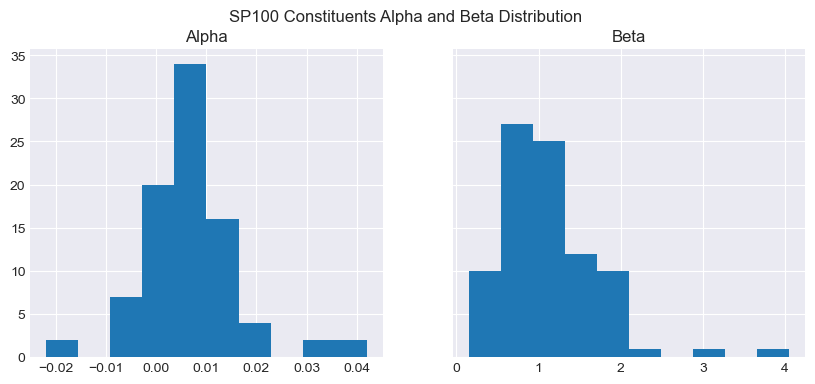

,alpha,beta
AAPL,0.032667,1.693059
ABT,-0.001708,0.154790
ACN,0.008494,0.917208
ADBE,-0.004991,1.721084
AIG,-0.021898,4.052381
...,...,...
VZ,0.004918,0.769907
WBA,0.000419,1.183008
WFC,0.015630,1.019088
WMT,0.001754,0.305628


In [47]:
# SP100 excess returns within in sample period
x = df_sp_100_exrets_new.loc[:is_end_date,'SP100exret']

# Calculate excess return of each stock during in sample period
stocks_array = df_sp_100_exrets_new.loc[:is_end_date,'AAPL':'XOM'].values 
rf_array = df_sp_100_exrets_new.loc[:is_end_date,'rf'].values
rf_array = rf_array[:,np.newaxis]
y = stocks_array - rf_array # Array containing dependent variables in each column

# OLS Regression
X = sm.add_constant(x)
ts_res = sm.OLS(y, X, missing='drop').fit()

# alpha = ts_res.params[0]
# beta = ts_res.params[1:]

# Isolate alpha and beta
alpha = ts_res.params.iloc[0,:].values
beta = ts_res.params.iloc[1,:].values

# Plot Histogram of Alphas and Beta
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(10,4))
axs[0].hist(alpha)
axs[0].set_title('Alpha')
axs[1].hist(beta)
axs[1].set_title('Beta')
plt.suptitle('SP100 Constituents Alpha and Beta Distribution')
plt.show()

# Format parameter datframe
ts_res.params = ts_res.params.rename(index={'const': 'alpha', 'SP100exret': 'beta'})
ts_res.params.columns = SP100_list
display(ts_res.params.T)

In [48]:
# Excess return of stock = alpha + beta*excess returns on market

# SP100 excess returns within out of sample period
SP100_exret_os = df_sp_100_exrets_new.loc[os_start_date:,'SP100exret']

# stock_excess_return = alpha + beta*SP100_exret_os

# Isolate alpha and beta for each stock and repeat by length of os dataframe

aapl_alpha = ts_res.params.iloc[0,:][0]
aapl_beta = ts_res.params.iloc[1,:][0]

aapl_alpha_os = np.repeat(aapl_alpha, T_os)
aapl_beta_os = np.repeat(aapl_beta, T_os)
aapl_exret_os = aapl_alpha_os + aapl_beta_os*SP100_exret_os
aapl_exret_os


# Settting up empty dictionary
exret = {}

# Repeat for all 87 stocks (N=87)
alpha = ts_res.params.iloc[0,:]
beta = ts_res.params.iloc[1,:]

for i in range(N):
    alpha = np.repeat(alpha[i], T_os)
    beta = np.repeat(beta[i], T_os)
    ex_ret = alpha[i] + beta[i]*SP100_exret_os

    exret[i] = ex_ret
    
display(aapl_exret_os)
display(exret)

Date
2011-01-31    0.071916
2011-02-28    0.080706
2011-03-31    0.023268
2011-05-31    0.001744
2011-06-30    0.004054
                ...   
2022-03-31    0.096681
2022-05-31    0.024974
2022-06-30   -0.105856
2022-08-31   -0.051129
2022-09-30   -0.140993
Name: SP100exret, Length: 101, dtype: float64

{0: Date
 2011-01-31    0.071916
 2011-02-28    0.080706
 2011-03-31    0.023268
 2011-05-31    0.001744
 2011-06-30    0.004054
                 ...   
 2022-03-31    0.096681
 2022-05-31    0.024974
 2022-06-30   -0.105856
 2022-08-31   -0.051129
 2022-09-30   -0.140993
 Name: SP100exret, Length: 101, dtype: float64,
 1: Date
 2011-01-31    0.071916
 2011-02-28    0.080706
 2011-03-31    0.023268
 2011-05-31    0.001744
 2011-06-30    0.004054
                 ...   
 2022-03-31    0.096681
 2022-05-31    0.024974
 2022-06-30   -0.105856
 2022-08-31   -0.051129
 2022-09-30   -0.140993
 Name: SP100exret, Length: 101, dtype: float64,
 2: Date
 2011-01-31    0.071916
 2011-02-28    0.080706
 2011-03-31    0.023268
 2011-05-31    0.001744
 2011-06-30    0.004054
                 ...   
 2022-03-31    0.096681
 2022-05-31    0.024974
 2022-06-30   -0.105856
 2022-08-31   -0.051129
 2022-09-30   -0.140993
 Name: SP100exret, Length: 101, dtype: float64,
 3: Date
 2011-01-31    0.071916
 201

In [49]:
# Estimate a

# A equals the weights under the global mean variance portfolio

In [50]:
# Estimate b

#### Out-of-Sample Portfolio 2

### Portfolio Evaluation

In [51]:
# Appending MVP and EW portfolios to Out-of-Sample dataframe

df_os['MVP'] = r_mvp_os
df_os['EW'] = df_os.loc[:,'AAPL':'XOM'].mean(axis = 1)
# df_os['P2'] = r_p2_os

# Add portfolio two

df_os['rf'] = df_sp_100_exrets_new.loc[os_start_date:,'rf']
df_os['SP100'] = df_sp_100_exrets_new.loc[os_start_date:,'SP100']
# df_os = df_os[['MVP', 'EW', 'rf', 'SP100']] # Add portfolio two
display(df_os)

,AAPL,ABT,ACN,ADBE,AIG,AMGN,AMT,AMZN,AXP,BA,...,USB,VZ,WBA,WFC,WMT,XOM,MVP,EW,rf,SP100
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-31,0.050655,-0.059113,0.059641,0.071156,-0.356278,0.003273,-0.015220,-0.059278,0.010660,0.062660,...,0.002953,-0.004482,0.037284,0.045111,0.044429,0.098389,-0.003955,0.019697,0.0001,0.023282
2011-02-28,0.040119,0.072310,0.000195,0.042938,0.101905,-0.070511,0.059166,0.021288,0.008474,0.035766,...,0.026678,0.048886,0.069257,-0.004948,-0.075742,0.058376,-0.017561,0.024997,0.0001,0.028474
2011-03-31,-0.013396,0.019558,0.065594,-0.039615,-0.053198,0.040471,-0.040467,0.038712,0.036729,0.032106,...,-0.048016,0.042944,-0.072561,-0.015700,0.001346,-0.011248,-0.045893,0.001041,0.0001,-0.005452
2011-05-31,-0.006591,0.013478,0.012632,0.031684,-0.088910,0.062888,0.058835,0.004484,0.054041,-0.022180,...,-0.008557,-0.009959,0.021078,-0.025750,0.004356,-0.052622,-0.186842,-0.004845,0.0000,-0.018265
2011-06-30,-0.035586,0.007057,0.051450,-0.096321,0.028366,-0.036845,-0.058453,0.038890,0.001936,-0.048708,...,-0.003522,0.008091,-0.023224,-0.006913,-0.031801,-0.019702,0.102260,-0.014001,0.0000,-0.016900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-31,0.057156,-0.018914,0.064960,-0.026125,0.024677,0.074075,0.101952,0.059624,-0.039529,-0.069779,...,-0.061830,-0.052206,-0.019024,-0.092030,0.096950,0.062834,0.052989,0.020140,0.0001,0.037910
2022-05-31,-0.057505,0.038273,-0.003373,0.050550,0.002901,0.096210,0.066136,-0.033313,-0.031460,-0.124626,...,0.088812,0.114457,0.033170,0.047884,-0.173432,0.118760,0.063758,0.015331,0.0003,-0.004244
2022-06-30,-0.083469,-0.077966,-0.072275,-0.129041,-0.137728,-0.045766,-0.002111,-0.123818,-0.197097,0.039689,...,-0.142536,-0.010584,-0.133689,-0.150266,-0.052739,-0.104005,-0.080850,-0.081020,0.0006,-0.081218


In [52]:
df_os.describe()

,AAPL,ABT,ACN,ADBE,AIG,AMGN,AMT,AMZN,AXP,BA,...,USB,VZ,WBA,WFC,WMT,XOM,MVP,EW,rf,SP100
count,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,...,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000
mean,0.017192,0.009946,0.011376,0.014639,-0.002721,0.009962,0.009133,0.016189,0.010600,0.004239,...,0.004474,0.002967,0.002297,0.002492,0.006662,0.000106,0.085102,0.007251,0.000445,0.005842
std,0.078872,0.049231,0.060681,0.078786,0.099387,0.061371,0.055809,0.081465,0.066710,0.104296,...,0.061967,0.045935,0.076633,0.070294,0.051837,0.070239,1.482535,0.041466,0.000677,0.041498
min,-0.203396,-0.118722,-0.159084,-0.305259,-0.553055,-0.166962,-0.168289,-0.225887,-0.250042,-0.606353,...,-0.298652,-0.113184,-0.209026,-0.342397,-0.173432,-0.289365,-4.088253,-0.144270,0.000000,-0.109149
25%,-0.031422,-0.020651,-0.025696,-0.042607,-0.052907,-0.030850,-0.026769,-0.048751,-0.018197,-0.038655,...,-0.026563,-0.020849,-0.038188,-0.024628,-0.029056,-0.033799,-0.162132,-0.010566,0.000000,-0.010302
50%,0.016486,0.007663,0.018879,0.028268,0.017959,0.012716,0.008577,0.021288,0.010660,0.010327,...,0.014060,0.001821,-0.001619,0.012121,0.008503,-0.002262,-0.009065,0.012437,0.000100,0.013057
75%,0.073061,0.040680,0.049736,0.060796,0.058677,0.041171,0.054213,0.065184,0.051993,0.048521,...,0.040964,0.033910,0.045814,0.036400,0.040958,0.038754,0.186671,0.028569,0.000600,0.030656
max,0.194233,0.154459,0.148338,0.196223,0.199428,0.165509,0.108290,0.238150,0.266347,0.377965,...,0.120998,0.114457,0.206371,0.242992,0.110963,0.216223,11.911121,0.119106,0.002100,0.119358


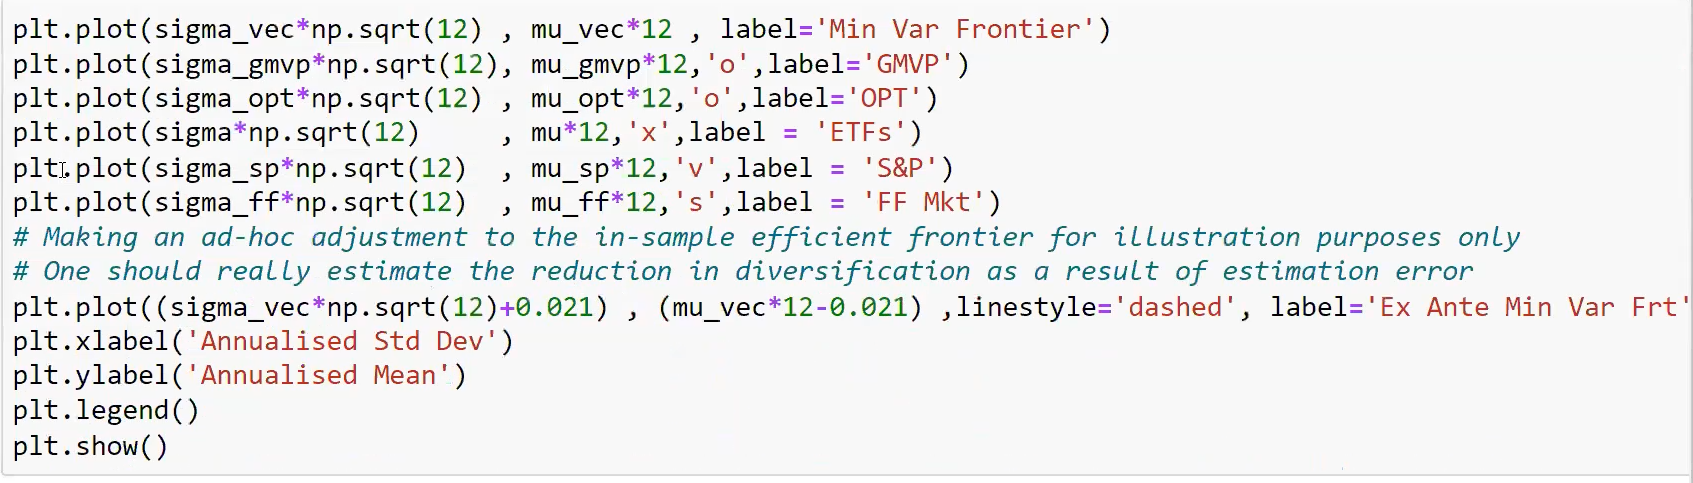
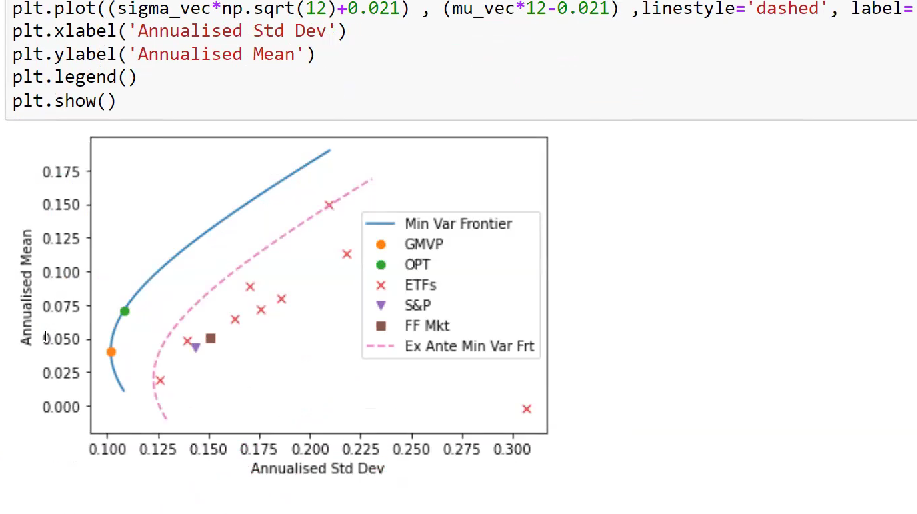

#### Gains from Diversification

_Two Asset Example: Apple (AAPL) and Abbott Laboratories(ABT)

AAPL annualised mean is 0.39
ABT annualised mean is 0.001
AAPL annualised std is 0.438
ABT annualised std is 0.173
AAPL and ABT correlation coffecient is -0.096


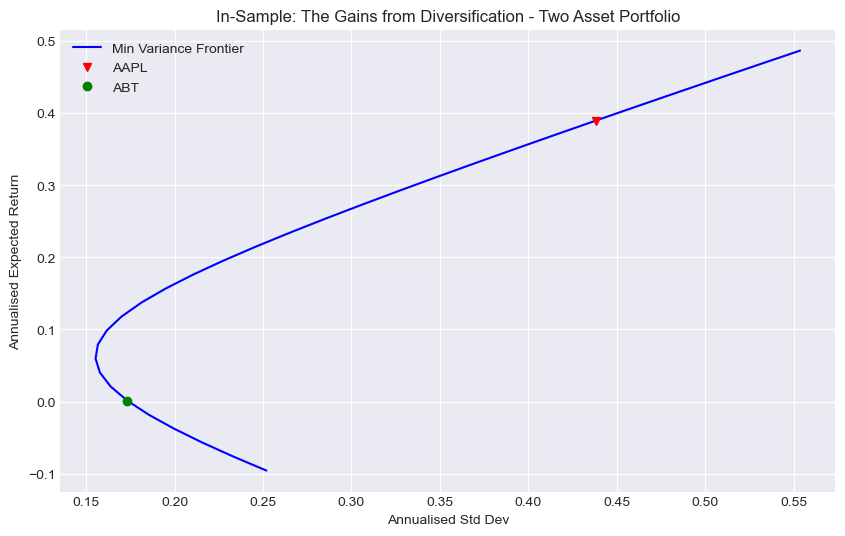

In [69]:
# Two asset example AAPL and ABT

# Monthly means, standard deviations and correlations
mu_appl = np.mean(df_is['AAPL'])
mu_abt = np.mean(df_is['ABT'])
sigma_appl = np.std(df_is['AAPL'])
sigma_abt = np.std(df_is['ABT'])
rho = df_is['AAPL'].corr(df_is['ABT'])

# Annualised means, standard deviations and correlations
mu_appl_annual = mu_appl*12
mu_abt_annual = mu_abt*12
sigma_appl_annual = sigma_appl*np.sqrt(12)
sigma_abt_annual = sigma_abt*np.sqrt(12)

print("AAPL annualised mean is", np.round(mu_appl_annual,3))
print("ABT annualised mean is", np.round(mu_abt_annual,3))
print("AAPL annualised std is", np.round(sigma_appl_annual,3))
print("ABT annualised std is", np.round(sigma_abt_annual,3))
print("AAPL and ABT correlation coffecient is", np.round(rho,3))

# w is a 1d array of weights
w = np.linspace(-0.25, 1.25, 31)

# Portfolio expected return
mu_port = w*mu_appl_annual + (1-w)*mu_abt_annual

# Portfolio variance and standard deviation
var_port = (w**2)*sigma_appl_annual**2 + ((1-w)**2)*sigma_abt_annual**2 + 2*w*(1-w)*rho*sigma_appl_annual*sigma_abt_annual
sigma_port = np.sqrt(var_port)

# Plot
# plt.plot(sigma_port, mu_port,'b-', sigma_appl_annual, mu_appl_annual, 'rv', sigma_abt_annual, mu_abt_annual,'go')
plt.plot(sigma_port, mu_port,'b-', label='Min Variance Frontier')
plt.plot(sigma_appl_annual, mu_appl_annual, 'rv', label='AAPL')
plt.plot(sigma_abt_annual, mu_abt_annual,'go', label='ABT')
plt.xlabel('Annualised Std Dev')
plt.ylabel('Annualised Expected Return')
plt.title('In-Sample: The Gains from Diversification - Two Asset Portfolio')
plt.legend()
plt.show()

_Multi Asset and Index Portfolios_

In [54]:
# In sample Fama French mean market return and std_dev (for plotting)

# Isolate array of FF market returns over in sample period 
ff_mkt_rf = df_sp_100_exrets_new.loc[:is_end_date,'mkt-rf'].values
rf = df_sp_100_exrets_new.loc[:is_end_date,'rf'].values
ff_mkt_ret = ff_mkt_rf + rf

# In-sample expected returns vector and standard deviation vector
ff_mu = ff_mkt_ret.mean() 
ff_sigma = ff_mkt_ret.std() 

In [55]:
# In sample SP100 mean market return and std_dev (for plotting)
 
sp100 = df_sp_100_exrets_new.loc[:is_end_date,'SP100'].values
sp100_mu = sp100.mean() 
sp100_sigma = sp100.std()

In [56]:
# In sample Equally Weighted portfolio return and std_dev (for plotting)

ew_port = df_is.loc[:,'AAPL':'XOM'].mean(axis = 1)
ew_port_mu = ew_port.mean() 
ew_port_sigma = ew_port.std()

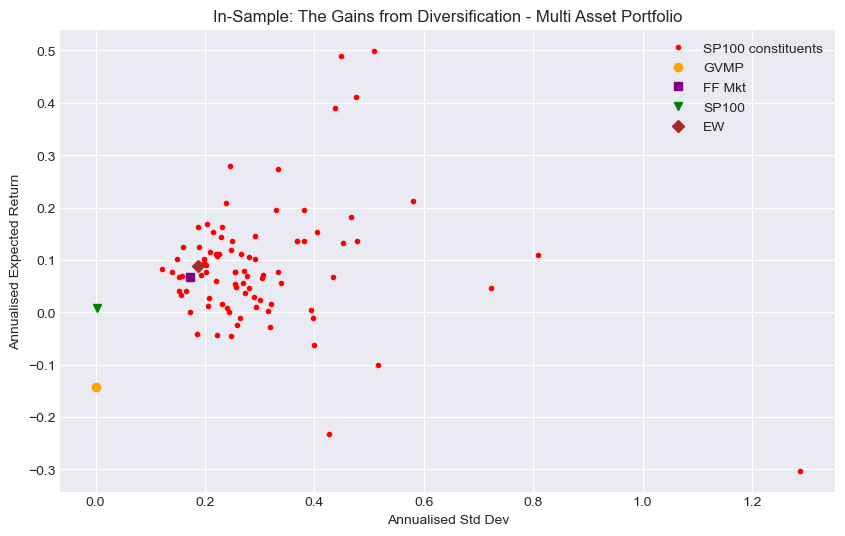

In [57]:
# Recreate graph with SP100 constituents assets, SP100, EW, FF, GMVP, portfolio returns (In sample)
# plt.plot(sigma_vec*np.sqrt(12), mu_vec*12, '-', label='Min Variance Frontier', color='blue')
plt.plot(sigma*np.sqrt(12), mu_1d*12, '.', label='SP100 constituents', color='red')
plt.plot(var_gmvp*np.sqrt(12), mu_gmvp*12, 'o', label='GVMP', color='orange')
plt.plot(ff_sigma*np.sqrt(12), ff_mu*12, 's', label='FF Mkt', color='purple')
plt.plot(sp100_mu*np.sqrt(12), sp100_mu*12, 'v', label='SP100', color='green')
plt.plot(ew_port_sigma*np.sqrt(12), ew_port_mu*12, 'D', label='EW', color='brown')
# plt.plot(p2_sigma*np.sqrt(12), p2_mu*12, 'o', label='Portfolio 2', color='cyan')

plt.xlabel('Annualised Std Dev')
plt.ylabel('Annualised Expected Return')
plt.title('In-Sample: The Gains from Diversification - Multi Asset Portfolio')
plt.legend()
plt.show()

#### Cumulative Returns

In [58]:
# Cumulative returns

cr_mvp = np.cumprod(1+df_os['MVP'])
cr_ew = np.cumprod(1+df_os['EW'])

# Add portfolio two

cr_mkt_sp = np.cumprod(1+df_sp_100_exrets_new.loc[os_start_date:,'SP100'])

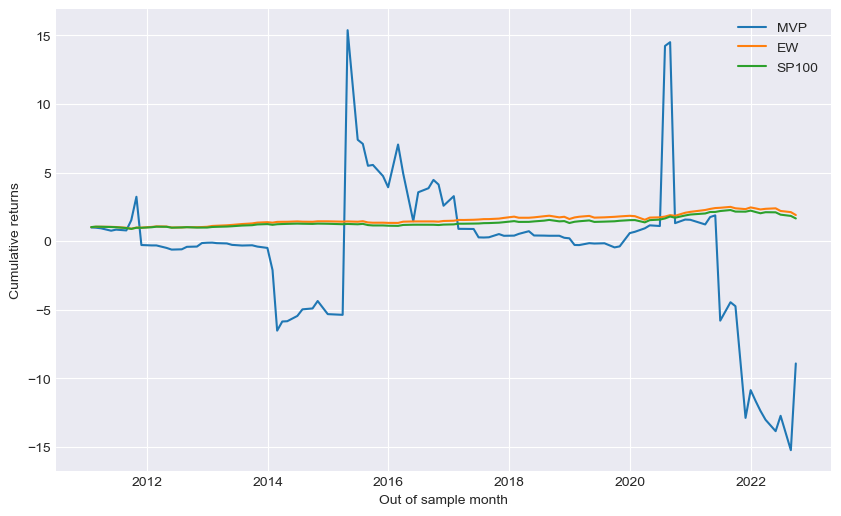

In [59]:
# Plot

plt.plot(cr_mvp, label = 'MVP')
plt.plot(cr_ew, label = 'EW')

# Add portfolio two

plt.plot(cr_mkt_sp, label = 'SP100')
plt.xlabel('Out of sample month')
plt.ylabel('Cumulative returns')
plt.legend()
plt.show()

#### Capital Asset Pricing Model
Use the CAPM model to evaluate the out-of-sample performance of the two portfolios. run an ex-post regression with the excess portfolio returns as the dependent variable and the excess S&P 100 market returns as the independent variable.

In [60]:
# Calculcate excess returns
cols = ['MVP', 'EW', 'SP100'] # (replace EW with P2)
df_os_exret = df_os.apply(lambda x: x[cols] - x['rf'], axis=1)
df_os_exret.columns = ['exret' + str(col) for col in cols]
display(df_os_exret)

,exretMVP,exretEW,exretSP100
Date,,,
2011-01-31,-0.004055,0.019597,0.023182
2011-02-28,-0.017661,0.024897,0.028374
2011-03-31,-0.045993,0.000941,-0.005552
2011-05-31,-0.186842,-0.004845,-0.018265
2011-06-30,0.102260,-0.014001,-0.016900
...,...,...,...
2022-03-31,0.052889,0.020040,0.037810
2022-05-31,0.063458,0.015031,-0.004544
2022-06-30,-0.081450,-0.081620,-0.081818


In [61]:
portfolios = ['MVP', 'EW'] # Define list of portfolios (replace EW with P2)

In [65]:
# Regression
capm_model_result = {} #Setting up empty dictionary

for p in portfolios:
    Y = df_os_exret['exret' + p] #dependent variables
    X = df_os_exret['exretSP100'] #independent variable
    capm_model = smf.ols(formula='Y ~ X',data=df_os_exret) #estimate each OLS regression
    capm_name = 'SP100 CAPM Ex-Post Regression: ' + p #name each regression
    capm_regress_result = capm_model.fit() #fit each model
    print(capm_name, '\n', capm_regress_result.summary(), '\n') #print each regression

    capm_model_result[p] = capm_regress_result  #Filling dictionary with each model

SP100 CAPM Ex-Post Regression: MVP 
                             OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.009
Method:                 Least Squares   F-statistic:                    0.1003
Date:                Wed, 30 Nov 2022   Prob (F-statistic):              0.752
Time:                        12:54:00   Log-Likelihood:                -182.53
No. Observations:                 101   AIC:                             369.1
Df Residuals:                      99   BIC:                             374.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      

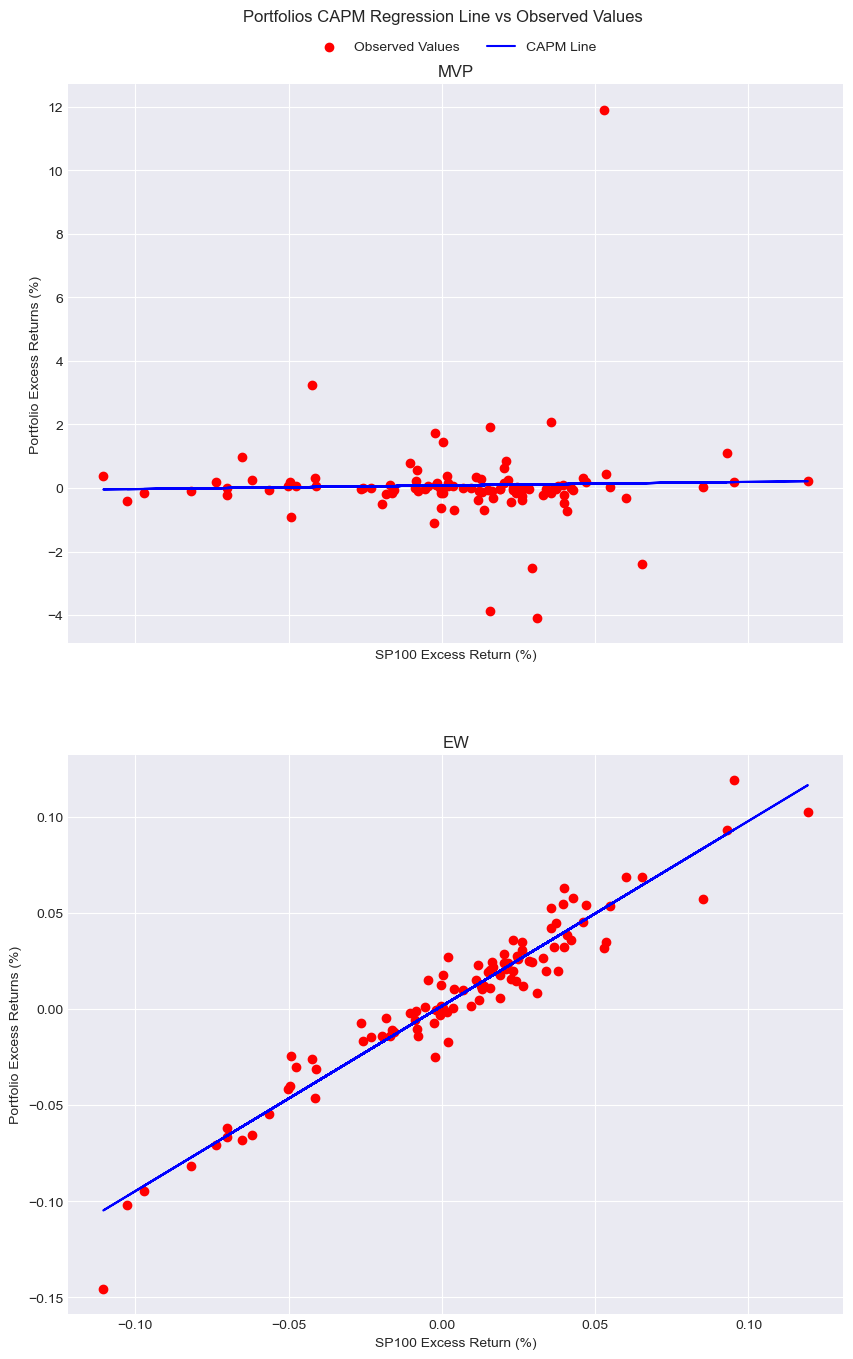

In [66]:
# Plot CAPM
fig, axs = plt.subplots(nrows=len(portfolios), ncols=1, figsize=(10,15), sharex=True)

for k, p in enumerate(portfolios):
    ax = axs[k]
    predict = capm_model_result[p].predict()
    ax.scatter(df_os_exret['exretSP100'], df_os_exret['exret' + p], 
               label='Observed Values', color = 'red') # plot observed values
    ax.plot(df_os_exret['exretSP100'], predict, label = 'CAPM Line', color = 'blue') # draw regression line
    ax.set_title(p)
    ax.set_xlabel("SP100 Excess Return (%)")
    ax.set_ylabel("Portfolio Excess Returns (%)")
plt.suptitle("Portfolios CAPM Regression Line vs Observed Values")
axs[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.1),ncol=2, fancybox=True, shadow=True) #Adjusting legend position
plt.subplots_adjust(top=0.93) #Adjusting title position
plt.show()

### Question 3 Commentary
xxxx

## Project Allocation

 - Odhran Murphy: Management of GitHub repository. Question 3. Formatting of code and report
 - Hugo Brady: Question 1
 - Mark Mullins: Question 2